In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) # make cells wider :)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from matplotlib.gridspec import  GridSpec

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

In [4]:
# Set n of columns displayed by pandas
pd.set_option('display.max_columns', 30)

In [5]:
# Check data location
!dir data\

 Volume in drive C is Windows
 Volume Serial Number is 5441-C8EF

 Directory of C:\Users\bialekj\Documents\Moje\Doktorat wdrozeniowy\wyklady\XAI\pd_1\data

10.03.2020  07:14    <DIR>          .
10.03.2020  07:14    <DIR>          ..
20.09.2019  02:54           374˙003 mushrooms.csv
               1 File(s)        374˙003 bytes
               2 Dir(s)  15˙955˙791˙872 bytes free


In [6]:
data_path = './data'
filename = 'mushrooms.csv'

In [7]:
# read data
df = pd.read_csv(os.path.join(data_path,filename))
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [9]:
# Show summary report
df.profile_report(title='Summary Report')

Remarks:
* Binary classification problem.
* All variables are of categorical type - seems that tree-based models should be good here.
* No missing values.
* Classes are well-balanced.
* Some of the features have rare observations (like cap-shape == 'c'). It might be important to take that into account in CV split, but we'll see.
* One constant parameter (veil-type) - to be checked.

In [8]:
# check if veil-type is constant
df['veil-type'].value_counts()

p    8124
Name: veil-type, dtype: int64

In [9]:
# drop 'veil-type'
df.drop(columns = ['veil-type'], inplace = True)
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [10]:
# Encode categorical variables
for col in df.columns:
    df[col]=LabelEncoder().fit_transform(df[col])
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,2,1,0,3,0,1


In [11]:
df['class'].value_counts()

0    4208
1    3916
Name: class, dtype: int64

In [12]:
# Lets just check default RF model
df = df.reset_index(drop=True) # make sure there are no duplicate indexes or whatever

In [13]:
# simple split into test and train-validation sub_sets
df_CV, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
df_CV = df_CV.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
len(df_CV), len(df_test)

(6499, 1625)

In [18]:
# simple func to get scores
def get_scores(y_true, y_pred, val_or_train):
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    AUROC = roc_auc_score(y_true,y_pred)
    keys = ['precision', 'recall', 'accuracy', 'AUROC']
    keys = [val_or_train + '_' + key for key in keys]
    vals = [precision,recall,accuracy,AUROC]
    dic = dict(zip(keys,vals))
    return dic

In [19]:
# cv train-val splits
y = df_CV['class']
X = df_CV.drop(columns=['class'])

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)
train_val_CV_splits = sss.split(X, y)

In [23]:
# double check always good
'class' in X.columns

False

In [24]:
summary_df = pd.DataFrame()
clf = RandomForestClassifier(max_depth=9, n_estimators=10, random_state=22)

for i, (train_index, val_index) in enumerate(train_val_CV_splits):
    clone_clf = clone(clf);
    X_train, X_val = X.loc[train_index,:], X.loc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]
    clone_clf.fit(X_train, y_train);
    
    print('\nFold '+str(i+1))
    print('Liczność val',len(val_index),'Liczność train',len(train_index))
    print('Udział klasy pozytywnej train:',round(list(y_train).count(1)/len(y_train),2),'Udział klasy pozytywnej val:',round(list(y_val).count(1)/len(y_val),2))
    
    y_val_pred = clone_clf.predict(X_val)
    y_train_pred = clone_clf.predict(X_train)
        
    train_scores = get_scores(y_train, y_train_pred, "train")
    val_scores = get_scores(y_val, y_val_pred, "val")
    merged = {'CV-fold':i+1, **val_scores, **train_scores}
    summary_df = summary_df.append(merged, ignore_index = True)


Fold 1
Liczność val 1300 Liczność train 5199
Udział klasy pozytywnej train: 0.48 Udział klasy pozytywnej val: 0.48

Fold 2
Liczność val 1300 Liczność train 5199
Udział klasy pozytywnej train: 0.48 Udział klasy pozytywnej val: 0.48

Fold 3
Liczność val 1300 Liczność train 5199
Udział klasy pozytywnej train: 0.48 Udział klasy pozytywnej val: 0.48

Fold 4
Liczność val 1300 Liczność train 5199
Udział klasy pozytywnej train: 0.48 Udział klasy pozytywnej val: 0.48

Fold 5
Liczność val 1300 Liczność train 5199
Udział klasy pozytywnej train: 0.48 Udział klasy pozytywnej val: 0.48


In [25]:
summary_df

,CV-fold,train_AUROC,train_accuracy,train_precision,train_recall,val_AUROC,val_accuracy,val_precision,val_recall
0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
1,2.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
2,3.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
3,4.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
4,5.0,0.999814,0.999808,0.999601,1.0,0.999257,0.999231,0.998408,1.0


Well.. what can I say. Lets train on the whole train-validation subset and test on the test set that was put aside at the begininng and see if these results are real.

In [26]:
y_test = df_test['class']
X_test = df_test.drop(columns=['class'])

clone_clf = clone(clf)
clone_clf.fit(X_test,y_test);
y_test_pred = clone_clf.predict(X_test)
get_scores(y_test, y_test_pred, "test")

{'test_precision': 1.0,
 'test_recall': 1.0,
 'test_accuracy': 1.0,
 'test_AUROC': 1.0}

I see no point in feature selection/hyperparameter tuning :). Lets have a quick look at feat importances.

Feature ranking:
1. feature 4 - cap-shape (0.188073)
2. feature 17 - cap-surface (0.186597)
3. feature 7 - cap-color (0.130985)
4. feature 18 - bruises (0.110091)
5. feature 6 - odor (0.059043)
6. feature 12 - gill-attachment (0.057048)
7. feature 8 - gill-spacing (0.051229)
8. feature 19 - gill-size (0.044998)
9. feature 10 - gill-color (0.042818)
10. feature 13 - stalk-shape (0.032415)
11. feature 3 - stalk-root (0.024938)
12. feature 9 - stalk-surface-above-ring (0.015890)
13. feature 2 - stalk-surface-below-ring (0.012335)
14. feature 20 - stalk-color-above-ring (0.011228)
15. feature 16 - stalk-color-below-ring (0.009049)
16. feature 1 - veil-color (0.006827)
17. feature 15 - ring-number (0.005950)
18. feature 14 - ring-type (0.005305)
19. feature 11 - spore-print-color (0.002317)
20. feature 5 - population (0.001446)
21. feature 0 - habitat (0.001416)


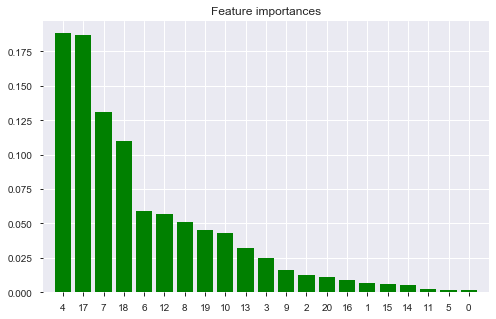

In [45]:
importances = clone_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))

# Plot the feature importances of the clone_clf
plt.figure(figsize=(8,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="g", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()